In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.dates as mdates


In [3]:
flow_df = pd.read_csv('../hcr_dat_border.csv')
flow_df.head()

,iso3,Country,data_date,Border_Crossings
0,BLR,Belarus,24/Feb/2022,136
1,BLR,Belarus,25/Feb/2022,34
2,BLR,Belarus,26/Feb/2022,172
3,BLR,Belarus,27/Feb/2022,48
4,BLR,Belarus,28/Feb/2022,18


In [4]:
#cleaning...
countries_of_interest = ['Slovakia', 'Hungary', 'Poland', 'Republic of Moldova']
flow_df = flow_df[flow_df.Country.isin(countries_of_interest)]
flow_df['data_date'] = pd.to_datetime(flow_df['data_date'], format='%d/%b/%Y')
flow_df.drop(columns=['iso3'], inplace=True)
flow_df.rename(columns={"data_date": 'date', ' Border_Crossings ' : 'border_crossings'}, inplace=True)
flow_df = flow_df.groupby(['date', 'Country']).sum()
flow_df.head()

border_crossings
date       Country                             
2022-02-24 Hungary                      19,978 
           Poland                       30,096 
           Republic of Moldova          10,928 
           Slovakia                      4,844 
2022-02-25 Hungary                      19,618

In [5]:
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace(',', '')
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace('-', '0')
flow_df['border_crossings'] = flow_df['border_crossings'].str.strip().astype('int')

In [6]:
#get trends data
with open("trends_2022.pkl" , mode='rb') as f:
    trends_df = pickle.load(f)

In [7]:
trends_df = trends_df.rename(columns={'external_city' : 'external_locations'})
trends_df.head()

travel     oblast  internal_city  external_locations
date       macro                                                         
2022-01-01 Center  3.283887   9.228542       4.956069            2.031719
           North   4.836938   8.208735       6.143003            1.588092
           South   1.558815   2.800135       3.856104            0.777124
           Kyiv    1.246112   1.300744       2.734151            0.358310
           West    8.351134  14.442794       8.099452            4.691871

In [8]:
trends_df[(trends_df == 0).any(axis=1)].index.values.tolist()
trends_df = trends_df.loc[~(trends_df==0).any(axis=1)]

In [9]:
trends_combine = trends_df.groupby(['date']).sum()
trends_combine.reset_index(inplace=True)
trends_combine

,date,travel,oblast,internal_city,external_locations
0,2022-01-01,22.103873,37.169065,28.402384,10.381487
1,2022-01-02,21.674791,38.984798,28.587606,10.308482
2,2022-01-03,20.508216,39.011884,29.585090,9.741498
3,2022-01-04,20.325353,39.187670,31.009361,8.339385
4,2022-01-05,19.395757,37.233726,29.584878,8.261052
...,...,...,...,...,...
147,2022-05-28,17.948715,41.064149,30.485619,14.242975
148,2022-05-29,27.846098,42.157297,30.420314,13.899248
149,2022-05-30,15.883621,41.941789,30.764554,12.516938
150,2022-05-31,17.381157,41.960837,30.617170,13.025198


In [10]:
trends_df = trends_df.groupby(['date', 'macro']).sum()
trends_df

travel     oblast  internal_city  external_locations
date       macro                                                         
2022-01-01 Center  3.283887   9.228542       4.956069            2.031719
           East    2.826987   1.188115       2.613605            0.934371
           Kyiv    1.246112   1.300744       2.734151            0.358310
           North   4.836938   8.208735       6.143003            1.588092
           South   1.558815   2.800135       3.856104            0.777124
...                     ...        ...            ...                 ...
2022-06-01 East    4.497957   2.505826       5.322186            0.858876
           Kyiv    1.024364   1.348201       2.066436            0.522294
           North   5.322329   9.346856       5.940232            2.125194
           South   1.888839   3.082430       4.899873            1.209760
           West    7.076723  16.542825       8.324960            6.563683

[912 rows x 4 columns]

In [11]:
for column in trends_df.columns:
    print(column)
    print(trends_df[column].idxmax())

travel
(Timestamp('2022-02-24 00:00:00'), 'West')
oblast
(Timestamp('2022-03-04 00:00:00'), 'West')
internal_city
(Timestamp('2022-03-03 00:00:00'), 'East')
external_locations
(Timestamp('2022-02-25 00:00:00'), 'West')


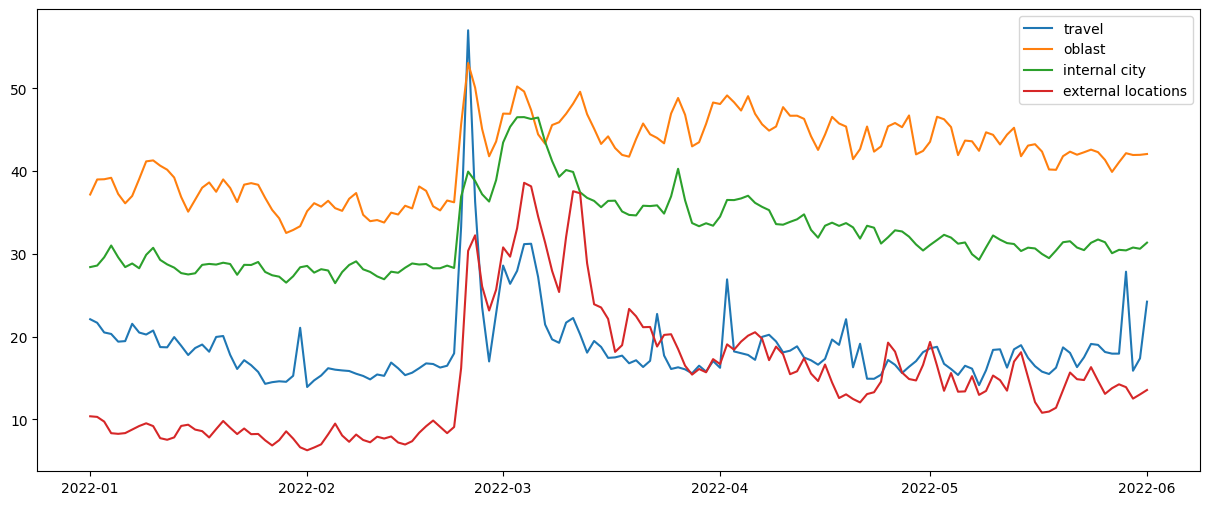

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
searches = trends_combine.columns[1:]
for r in searches:
    plt.plot(trends_combine.date, trends_combine[r], label = r.replace('_', ' '))
plt.legend()
plt.savefig("trends_allregions.png")

In [13]:
print(trends_df.dtypes)

travel                float64
oblast                float64
internal_city         float64
external_locations    float64
dtype: object


In [14]:
merged_df = flow_df.join(trends_df.reindex(trends_df.index, level=0))
merged_df.head()
len(merged_df)

2907

In [15]:
#group so macro regionsare all combined
df_nomacro = merged_df.groupby(['date', 'Country']).sum()
df_nomacro

border_crossings     travel     oblast  \
date       Country                                                       
2022-02-24 Hungary                        119868  57.005667  53.058785   
           Poland                         180576  57.005667  53.058785   
           Republic of Moldova             65568  57.005667  53.058785   
           Slovakia                        29064  57.005667  53.058785   
2022-02-25 Hungary                        117708  36.296789  50.073004   
...                                          ...        ...        ...   
2022-10-17 Republic of Moldova              1083   0.000000   0.000000   
           Slovakia                         1637   0.000000   0.000000   
2022-10-18 Hungary                          5071   0.000000   0.000000   
           Poland                          21369   0.000000   0.000000   
           Slovakia                         1809   0.000000   0.000000   

                                internal_city  external_locations  
date       Country                                                 
2022-02-24 Hungary                  39.936770           30.363210  
           Poland                   39.936770           30.363210  
           Republic of Moldova      39.936770           30.363210  
           Slovakia                 39.936770           30.363210  
2022-02-25 Hungary                  38.802839           32.239871  
...                                       ...                 ...  
2022-10-17 Republic of Moldova       0.000000            0.000000  
           Slovakia                  0.000000            0.000000  
2022-10-18 Hungary                   0.000000            0.000000  
           Poland                    0.000000            0.000000  
           Slovakia                  0.000000            0.000000  

[947 rows x 5 columns]

In [16]:
df_nomacro = df_nomacro.loc[(df_nomacro[['travel', 'oblast', 'internal_city', 'external_locations']] != 0).all(axis=1)]
df_nomacro


border_crossings     travel     oblast  \
date       Country                                                       
2022-02-24 Hungary                        119868  57.005667  53.058785   
           Poland                         180576  57.005667  53.058785   
           Republic of Moldova             65568  57.005667  53.058785   
           Slovakia                        29064  57.005667  53.058785   
2022-02-25 Hungary                        117708  36.296789  50.073004   
...                                          ...        ...        ...   
2022-05-31 Slovakia                        16338  17.381157  41.960837   
2022-06-01 Hungary                         32250  24.226485  42.062711   
           Poland                         124470  24.226485  42.062711   
           Republic of Moldova              7200  24.226485  42.062711   
           Slovakia                        16548  24.226485  42.062711   

                                internal_city  external_locations  
date       Country                                                 
2022-02-24 Hungary                  39.936770           30.363210  
           Poland                   39.936770           30.363210  
           Republic of Moldova      39.936770           30.363210  
           Slovakia                 39.936770           30.363210  
2022-02-25 Hungary                  38.802839           32.239871  
...                                       ...                 ...  
2022-05-31 Slovakia                 30.617170           13.025198  
2022-06-01 Hungary                  31.353995           13.558005  
           Poland                   31.353995           13.558005  
           Republic of Moldova      31.353995           13.558005  
           Slovakia                 31.353995           13.558005  

[392 rows x 5 columns]

In [17]:
countries = merged_df.index.get_level_values('Country').unique()
corr_matrix = np.zeros([len(countries),len(searches)])
with open('trend_flow_corrs.txt', 'w') as f:
    for i,c in enumerate(countries):
        for j,r in enumerate(searches):
            flow = df_nomacro.xs(c, level=1).border_crossings
            trends = df_nomacro.xs(c, level=1)[r]
            corr = np.corrcoef(flow.values, trends.values)[0][1]
            corr_str = c + ', ' + r + ' = ' + str(corr)
            f.write(corr_str)
            f.write('\n')
            corr_matrix[i,j] = corr

In [18]:
fig = plt.figure()
plt.imshow(corr_matrix, cmap = plt.get_cmap('Blues'), vmin = 0, vmax = 1)
plt.colorbar()
ax = plt.gca()
#ax.set_xticklabels(vars)
ax.set_yticks(np.arange(len(countries)))
ax.set_yticklabels(countries)
search_labels = [s.replace('_', ' ') for s in searches]
ax.set_xticks(np.arange(len(searches)))
ax.set_xticklabels(search_labels)
plt.xticks(rotation=90)
#ax.xaxis.set_xticks(vars)
plt.tight_layout()
plt.savefig("corr_flow_trends.png")
plt.close()

In [19]:
combine_country = flow_df.groupby(['date']).sum()
combine_country.head()

,border_crossings
date,
2022-02-24,65846
2022-02-25,90155
2022-02-26,131865
2022-02-27,154046
2022-02-28,149041


In [20]:
trends_nomacro = trends_df.groupby(['date']).sum()
trends_nomacro.head()

,travel,oblast,internal_city,external_locations
date,,,,
2022-01-01,22.103873,37.169065,28.402384,10.381487
2022-01-02,21.674791,38.984798,28.587606,10.308482
2022-01-03,20.508216,39.011884,29.585090,9.741498
2022-01-04,20.325353,39.187670,31.009361,8.339385
2022-01-05,19.395757,37.233726,29.584878,8.261052


In [21]:
df_nocountry = combine_country.join(trends_nomacro.reindex(trends_nomacro.index, level=0))
df_nocountry = df_nocountry.loc[(df_nocountry[['travel', 'oblast', 'internal_city', 'external_locations']] != 0).all(axis=1)]
df_nocountry = df_nocountry.dropna()
df_nocountry

,border_crossings,travel,oblast,internal_city,external_locations
date,,,,,
2022-02-24,65846,57.005667,53.058785,39.936770,30.363210
2022-02-25,90155,36.296789,50.073004,38.802839,32.239871
2022-02-26,131865,23.577730,45.078000,37.200613,26.070787
2022-02-27,154046,17.006390,41.786672,36.318221,23.158371
2022-02-28,149041,22.821920,43.571746,38.910562,25.667248
...,...,...,...,...,...
2022-05-28,34874,17.948715,41.064149,30.485619,14.242975
2022-05-29,29869,27.846098,42.157297,30.420314,13.899248
2022-05-30,28944,15.883621,41.941789,30.764554,12.516938


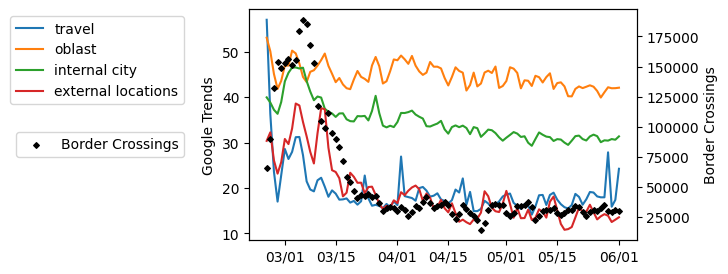

In [50]:
fig, ax = plt.subplots(figsize=(5, 3))
searches = df_nocountry.columns[1:]
for r in searches:
    plt.plot(df_nocountry.index.get_level_values('date'), df_nocountry[r], label=r.replace('_', ' '))
plt.legend(fontsize=10, bbox_to_anchor=(-0.15, 1))
ax1 = ax.twinx()
ax1.scatter(df_nocountry.index.get_level_values('date'), df_nocountry['border_crossings'], marker='D', color='black', label='Border Crossings', s=8)
ax1.legend(fontsize=10, bbox_to_anchor=(-0.15, 0.5))
xtick_locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(fontsize=10)
plt.xlabel('Date', fontsize=12)
plt.yticks(fontsize=10)
ax.set_ylabel('Google Trends')
ax1.set_ylabel('Border Crossings')
plt.savefig('trends_flow_big.png')
plt.show()